In [1]:
# importing libraries
import math
import pandas_datareader as pdr
import pandas as pd
import numpy as np


from datetime import datetime
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
# for tsa 
import statsmodels.api as sm
# holt's linear trend model. 
from statsmodels.tsa.api import Holt
import seaborn as sns
from matplotlib import pyplot


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import prepare 

# Stock Prices Predictor

## Project goals

#### create a model that predicts stock future prices based on historical prices 
#### achieve the goal using deep learning neuro network Long Short-Term Memory


## Acquiring and Preparing Stock Data
#### - Data is acquired from Yahoo finance from 2007-01-01 to 2022-06-30
#### - Engineered features: simple moving average(sma), percent_change
#### - Data has 2979 rows, 6 columns before cleaning and 2979 rows and 4 columns after
#### -  columns dropped : 
    "Open", "High", "Low", "Adj_Close"
#### - Split the data into train, validate, test
#### - Scaled data using a min-max scaler
#### - The fear and greed index is scraped from CNN website. They use a list of different financial instruments to that indicate fear as the lower number as the fear index and the higher numbers as the greed portion

In [2]:
#get the stock quote
df = pdr.DataReader("SPY",data_source = "yahoo", start = "2011-01-03", end = "2022-11-01")
df = prepare.wrangle_spy(df)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2979 entries, 2011-01-03 to 2022-11-01
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           2979 non-null   float64
 1   Volume          2979 non-null   float64
 2   sma             2979 non-null   float64
 3   percent_change  2979 non-null   float64
dtypes: float64(4)
memory usage: 116.4 KB


In [4]:
#import fear and greed index 
fear_greed_df = pd.read_csv("fear_greed_index.csv", index_col = [0], parse_dates = [0])

In [5]:
fear_greed_df.head()

,fear_greed_index
date,
2011-01-03,68.0
2011-01-04,68.0
2011-01-05,67.0
2011-01-06,64.0
2011-01-07,63.0


In [6]:
fear_greed_df.tail()

,fear_greed_index
date,
2022-10-27,57.0
2022-10-28,60.0
2022-10-31,58.0
2022-11-01,57.0
2022-11-01,57.0


In [7]:
main_df = pd.concat([df, fear_greed_df], axis=1)

In [8]:
# no null entries
main_df.isna().mean()

Close               0.0
Volume              0.0
sma                 0.0
percent_change      0.0
fear_greed_index    0.0
dtype: float64

In [9]:
train, validate, test = prepare.split_data(main_df)
train.head()

,Close,Volume,sma,percent_change,fear_greed_index
2011-01-03,127.050003,138725200.0,127.050003,0.002683,68.0
2011-01-04,126.980003,137409700.0,127.015003,-0.002749,68.0
2011-01-05,127.639999,133975300.0,127.223335,0.008374,67.0
2011-01-06,127.389999,122519000.0,127.265001,-0.002349,64.0
2011-01-07,127.139999,156034600.0,127.240001,-0.003293,63.0


# Exploration

## The following questions arose after doing some of domain research:
#### is there visible seasonality?
#### does any of the features have a normal distribution?
#### does the volume have a  relationship with the Closing price?

## Visualizing stock chart with the different splits (Train, Validate and Test)


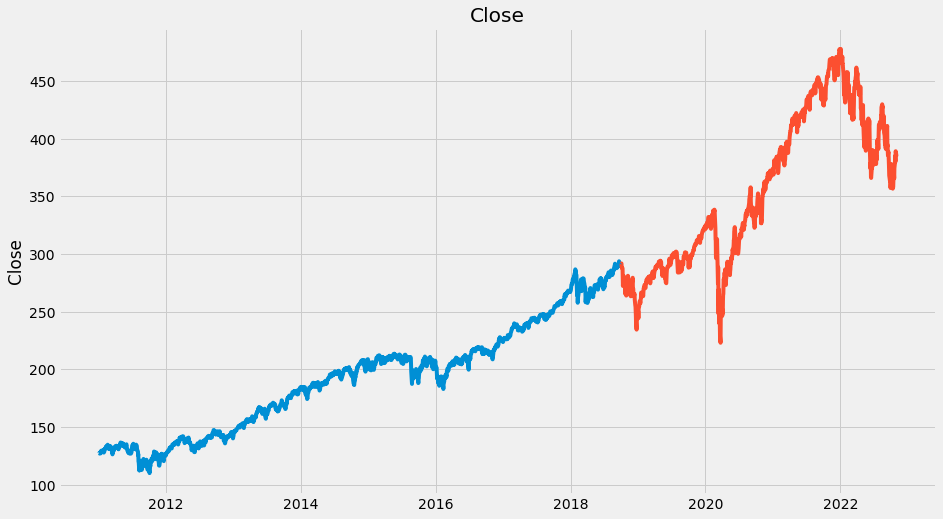

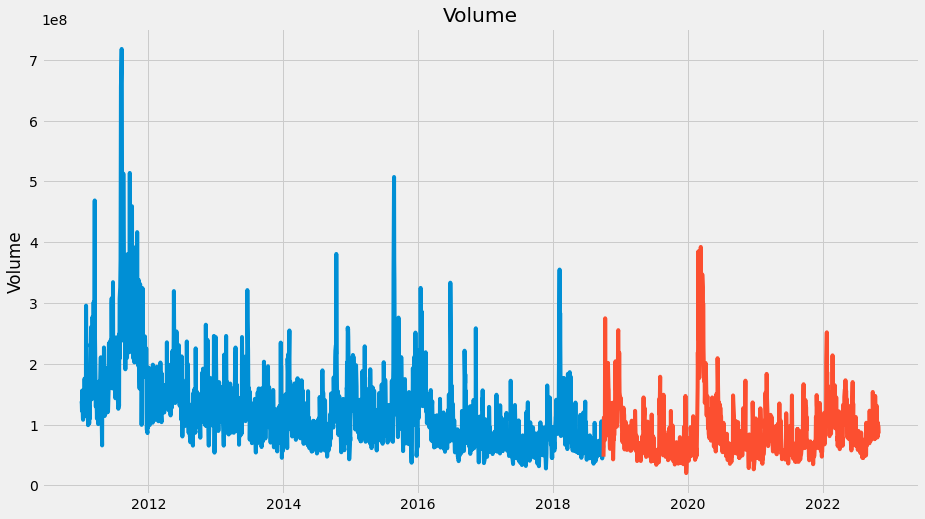

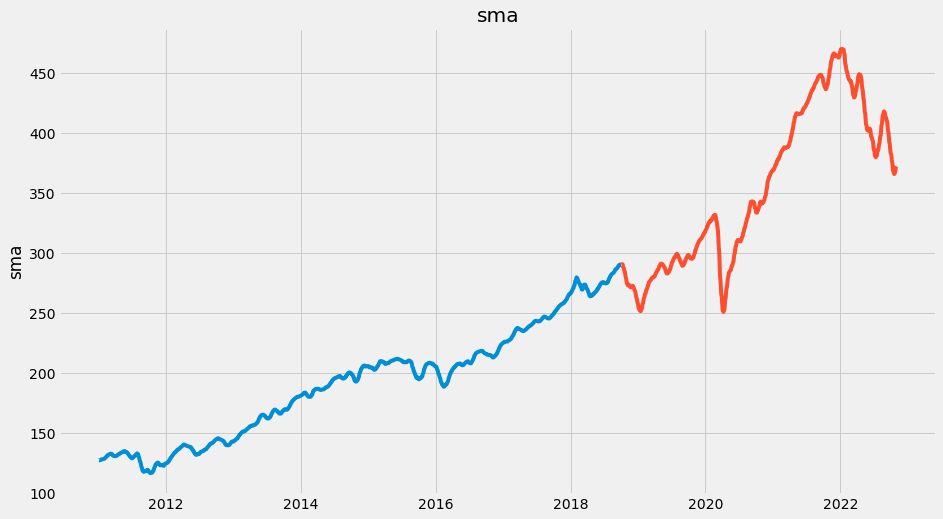

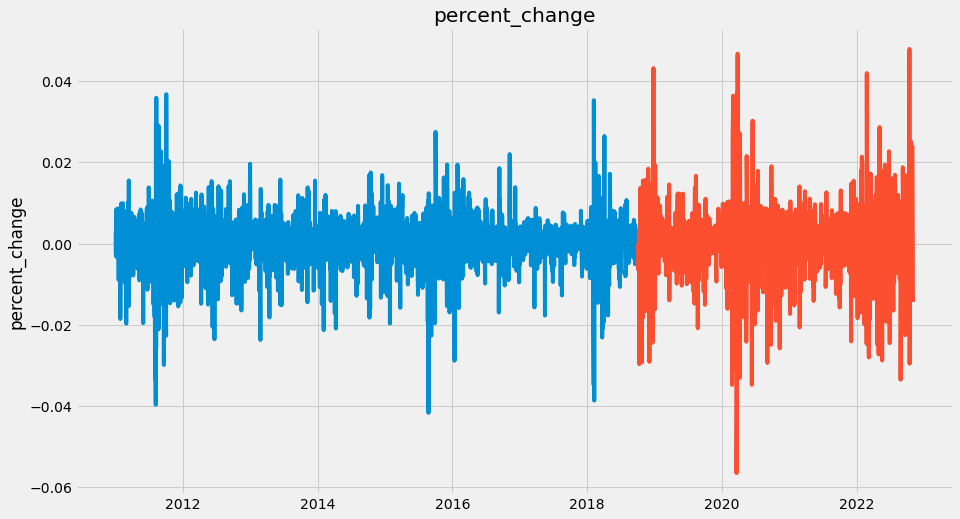

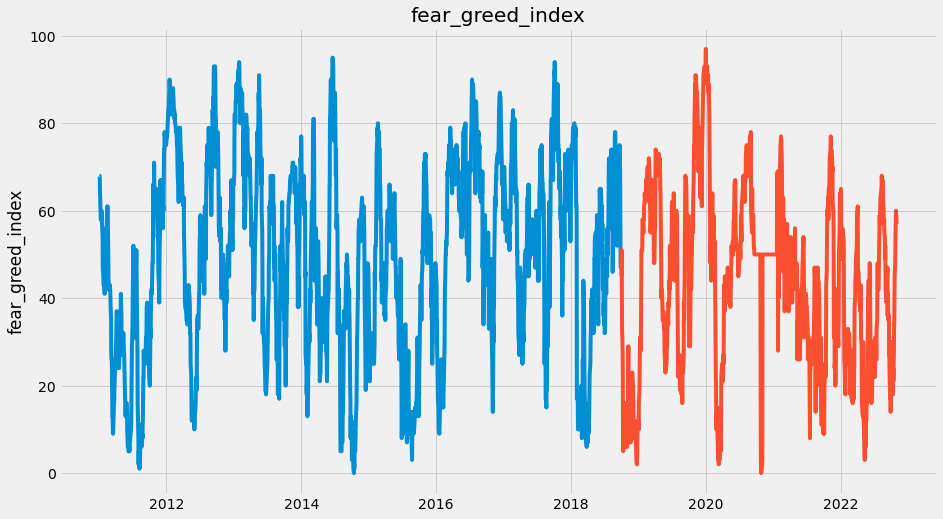

In [10]:
#visualizing stock chart with the different splits (Train, Validate and Test)
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

array([[<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Volume'}>],
       [<AxesSubplot:title={'center':'sma'}>,
        <AxesSubplot:title={'center':'percent_change'}>],
       [<AxesSubplot:title={'center':'fear_greed_index'}>,
        <AxesSubplot:>]], dtype=object)

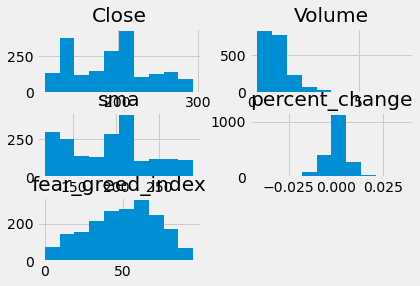

In [11]:
train.hist()

# Binning the fear and greed index  

In [12]:
labels = ["extreme_fear", "fear", "neutral", "greed", "extreme_greed"]
bins = [0,24,44,54,74,100]

In [13]:
main_df['fear_greed_bins'] = pd.cut(main_df['fear_greed_index'], bins=bins, labels=labels, include_lowest=True)

In [14]:
main_df.sample(5)

,Close,Volume,sma,percent_change,fear_greed_index,fear_greed_bins
2012-07-25,133.960007,129122300.0,135.373999,-0.001863,51.0,neutral
2016-12-22,225.380005,56219100.0,223.816000,-0.000975,71.0,greed
2011-04-14,131.559998,161220400.0,131.664501,0.006580,30.0,fear
2012-11-23,141.350006,65409200.0,139.672501,0.008706,47.0,neutral
2019-10-16,298.399994,48928200.0,295.096497,0.000101,47.0,neutral


In [16]:
main_df.to_csv("fear_greed_main_df.csv", index = 0)

## Visualizing SMA (simple moving average)

In [ ]:
# visualize the S&P 500  data
plt.figure(figsize =(16,8))
plt.title("Close Price History")
plt.plot(train["Close"])
plt.plot(train["sma"])
# plt.plot(train["Volume"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD($)", fontsize = 18)
plt.show()

## Visualizing price and volume looking for trends

In [ ]:
#visualizing volume and price
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(train.index, train["Close"])
plt.title('Historical stock prices of S&P 500. [01-04-2020 to 30-09-2020]')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(train.index, train['Volume'])
plt.title('\nS&P 500. Trading Volume', y=-0.60)
plt.gcf().set_size_inches(12,8)

## Visualizing returns vs fear and greed index

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize =(16,8))
# make a plot
ax.plot(train.index,
        train.Close,
        color="blue", 
        marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize = 14)
# set y-axis label
ax.set_ylabel("S&P $",
              color="blue",
              fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(train.index, train["fear_greed_index"],color="red",marker="o")
ax2.set_ylabel("fear & greed index",color="red",fontsize=14)
plt.show()

In [ ]:
train.corr()

## Takeaways are the chart is very noisy...

## converting data to monthly average

In [ ]:
train_monthly = train.resample('1M').mean()


In [ ]:
train_monthly.head()

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize =(16,8))
# make a plot
ax.plot(train_monthly.index,
        train_monthly.percent_change,
        color="blue", 
        marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize = 14)
# set y-axis label
ax.set_ylabel("S&P $",
              color="blue",
              fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(train_monthly.index, train_monthly["fear_greed_index"],color="red",marker="o")
ax2.set_ylabel("fear & greed index",color="red",fontsize=14)
plt.show()

In [ ]:
corr = train_monthly.corr()

In [ ]:
sns.heatmap(corr, annot = True, )